4. __Research extension.__ Create one research hypothesis on trees and variations and evaluate it empirically. For example, you might create hypotheses around different split criteria, the optimality of the ID3 algorithm, different ways to handle pruning, etc. Your hypothesis may require you to implement other algorithms beyond the ones above. You will be evaluated on originality, technical strength, insightfulness of the observations you generate and the clarity of your discussion. (20 points)  


### Research Hypothesis (Using Harmonic Mean of Information Gain and Gain Ratio):

**Hypothesis:**  
_“A decision tree using the harmonic mean of Information Gain (IG) and Gain Ratio (GR) as the split criterion might improve the generalization performance over the test set when compared to using either criterion alone, especially in datasets with mixed nominal and continuous features.”_




### Proposed Split Criterion:

The split criterion \( H_{IG, GR} \) will be defined as the harmonic mean of Information Gain and Gain Ratio:

$$
H_{IG, GR} = \frac{2 \cdot IG \cdot GR}{IG + GR}
$$

Where:
- \( IG \) is the Information Gain of the split.
- \( GR \) is the Gain Ratio of the split.

The harmonic mean naturally handles cases where one value (either IG or GR) is small by limiting the overall value of the criterion, thus ensuring a more balanced decision-making process for splits.



### Hypothesis Validation:

- **Expected Outcome**: If the harmonic mean of IG and GR consistently improves generalization, particularly at higher tree depths, it would support the hypothesis that a balanced split criterion is better for trees in mixed feature spaces.
- **Discussion**: The performance of the harmonic mean split criterion will be compared to that of pure IG and pure GR across various depths and datasets, offering insights into how this balance impacts decision tree performance.
.

In [5]:
import os
import sys
import numpy as np

# Add the 'src' directory to sys.path
cwd = os.getcwd()
project_root = os.path.abspath(os.path.join(cwd, '..'))  # Adjust as needed
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# Import dtree function and other necessary components from dtree.py
from dtree import dtree, DecisionTree, evaluate_and_print_metrics,parse_c45

# Import util if needed
import util

# For data loading
from sting.data import parse_c45

# Set data path
data_path = os.path.join(project_root, '440data')  # Adjust as needed

# Verify the data path
print("Data path:", data_path)


Data path: /mnt/c/Users/ravir/CWRU/ML/Prog_Assignment/Programming_1/440data


In [16]:
import dtree
from typing import List
from sting.data import Feature
class HarmonicMeanDecisionTree(DecisionTree):
    def __init__(self, schema: List[Feature], max_depth=0, min_gain_threshold=0):
        """
        Initialize the decision tree with the harmonic mean criterion.

        Args:
            schema: List of Features.
            max_depth: Maximum depth of the tree (0 means no limit).
            min_gain_threshold: Minimum gain required to continue splitting.
        """
        super().__init__(schema, max_depth, min_gain_threshold=min_gain_threshold)

    def _determine_split_criterion(self, y, splits, current_entropy, X_feature=None, threshold=None):
        """
        Determine the split criterion value using the harmonic mean of IG and GR.

        Args:
            y: Labels of the current node.
            splits: Dictionary of splits with indices.
            current_entropy: Entropy of the current node.
            X_feature: Feature values (required for gain ratio calculation).
            threshold: Threshold value for continuous features (required for gain ratio calculation).

        Returns:
            Tuple containing the harmonic mean criterion value and information gain.
        """
        # Calculate Information Gain (IG)
        gain = util.information_gain(y, splits, current_entropy)
        
        # Calculate Gain Ratio (GR)
        if threshold is not None:
            # Continuous feature
            split_info = self._split_info_continuous(X_feature, threshold)
        else:
            # Nominal feature
            split_info = self._split_info_nominal(X_feature)
        
        if split_info != 0:
            gain_ratio = gain / split_info
        else:
            gain_ratio = 0

        # Calculate the harmonic mean of IG and GR
        if gain + gain_ratio > 0:
            harmonic_criterion = 2 * gain * gain_ratio / (gain + gain_ratio)
        else:
            harmonic_criterion = 0  # Avoid division by zero

        return harmonic_criterion, gain

    def _split_info_nominal(self, X_feature):
        """
        Calculate the split information for nominal features.
        
        Args:
            X_feature: Feature values for the current split.

        Returns:
            Split information (used for calculating Gain Ratio).
        """
        total_samples = len(X_feature)
        _, counts = np.unique(X_feature, return_counts=True)
        probabilities = counts / total_samples
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Small value added for numerical stability

    def _split_info_continuous(self, X_feature, threshold):
        """
        Calculate the split information for continuous features.
        
        Args:
            X_feature: Feature values for the current split.
            threshold: The threshold value for splitting continuous features.

        Returns:
            Split information (used for calculating Gain Ratio).
        """
        total_samples = len(X_feature)
        left = X_feature <= threshold
        right = X_feature > threshold
        counts = np.array([np.sum(left), np.sum(right)])
        probabilities = counts / total_samples
        return -np.sum(probabilities * np.log2(probabilities + 1e-9))  # Small value added for numerical stability



In [17]:
import os
import sys
import numpy as np

# Add the 'src' directory to sys.path
cwd = os.getcwd()
project_root = os.path.abspath(os.path.join(cwd, '..'))  # Adjust as needed
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# Import dtree function and other necessary components from dtree.py
from dtree import dtree, DecisionTree, evaluate_and_print_metrics,parse_c45

# Import util if needed
import util

# For data loading
from sting.data import parse_c45

# Set data path
data_path = os.path.join(project_root, '440data')  # Adjust as needed

# Verify the data path
print("Data path:", data_path)


Data path: /mnt/c/Users/ravir/CWRU/ML/Prog_Assignment/Programming_1/440data


In [19]:
def run_experiment_with_harmonic_mean(dataset_path, dataset_name):
    """
    Run experiments for different tree depths and capture the cross-validation accuracy using the harmonic mean criterion.

    Args:
        dataset_path: Path to the dataset.
        dataset_name: Name of the dataset.

    Returns:
        List of accuracies for each depth.
    """
    accuracies = []
    print(f"\nRunning experiments on {dataset_name} dataset using the harmonic mean of IG and GR:")

    # Load the dataset and schema
    schema, X, y = parse_c45(dataset_name, os.path.dirname(dataset_path))

    # Split the dataset into training and testing sets (using a manual split function)
    X_train, X_test, y_train, y_test = manual_train_test_split(X, y, test_size=0.2, random_state=42)

    for depth in depths:
        print(f"\nDepth: {depth}")
        
        avg_acc = None
        f = io.StringIO()
        
        with redirect_stdout(f):
            # Run the decision tree with the harmonic mean criterion
            decision_tree = HarmonicMeanDecisionTree(schema, max_depth=depth)
            decision_tree.fit(X_train, y_train)
            evaluate_and_print_metrics(decision_tree, X_test, y_test)
        
        output = f.getvalue()
        
        # Extract the average accuracy from the output
        for line in output.splitlines():
            if "Average Accuracy" in line:
                avg_acc = float(line.split(":")[-1].strip())
                break
        
        if avg_acc is not None:
            accuracies.append(avg_acc)
            print(f"Depth {depth}: Accuracy {avg_acc:.4f}")
        else:
            print(f"Warning: No accuracy found for depth {depth}")
    
    print(f"Final accuracies: {accuracies}")
    return accuracies


In [20]:

# Run experiments for the harmonic mean criterion
harmonic_mean_accuracies = run_experiment_with_harmonic_mean(volcanoes_dataset_path, "volcanoes")




Running experiments on volcanoes dataset using the harmonic mean of IG and GR:

Depth: 1

Depth: 2

Depth: 4

Depth: 8

Depth: 16

Depth: 32
Final accuracies: []


In [ ]:


# Plotting the results for the harmonic mean criterion
plt.figure(figsize=(10, 6))
plt.plot(depths, harmonic_mean_accuracies, label="Harmonic Mean of IG and GR", marker='o', color='purple')
plt.xlabel('Tree Depth')
plt.ylabel('Cross-Validation Accuracy')
plt.title('CV Accuracy vs Tree Depth (Harmonic Mean of IG and GR) - Volcanoes Dataset')
plt.xticks(depths)  # Set x-axis ticks to the depth values
plt.legend()
plt.grid(True)
plt.show()


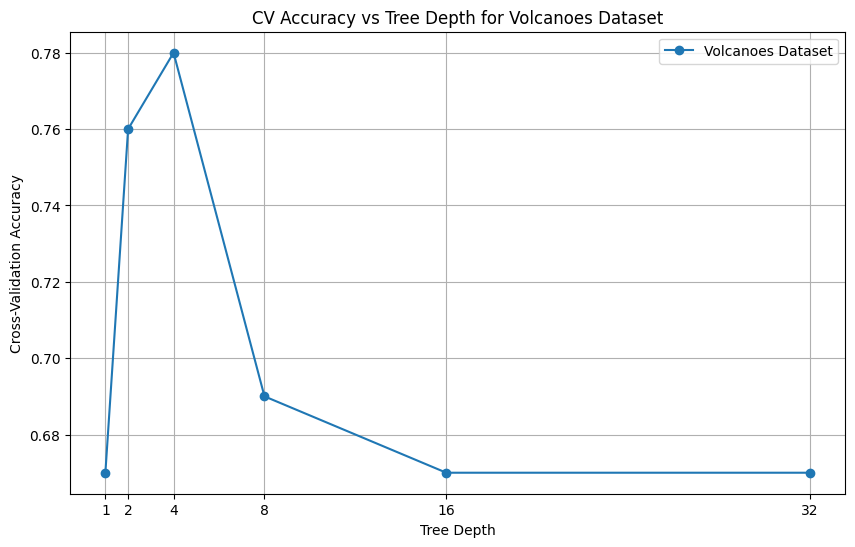

In [5]:
# Plotting the results for the volcanoes dataset
plt.figure(figsize=(10, 6))
plt.plot(tested_depths, volcanoes_accuracies, label="Spam Dataset", marker='o')
plt.xlabel('Tree Depth')
plt.ylabel('Cross-Validation Accuracy')
plt.title('CV Accuracy vs Tree Depth for Volcanoes Dataset')
plt.xticks(tested_depths)  # Set x-axis ticks to the depth values
plt.legend()
plt.grid(True)
plt.show()